In [2]:
import numpy as np
import pandas as pd
import scipy.optimize
from scipy import stats
import time
import arviz as az
import theano
import theano.tensor as tt
import GPy
from pyDOE import *
import pickle
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
import pymc3 as pm
from pymc3 import Model, Normal, Slice, sample, traceplot
from pymc3.distributions import Interpolated
import warnings
warnings.filterwarnings("ignore")

## Ground-truth data
strain_fe_media = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35]
stress_fe_media = [0, 0.00169707, 0.00336693, 0.00501758, 0.00665913, 0.00830489, 0.00997227, 0.0116837, 0.0134675, 0.0153589, 0.0174013, 0.0196476, 0.0221622, 0.0250236, 0.028327, 0.0321884, 0.0367485, 0.0421783, 0.0486846, 0.0565163, 0.0659717, 0.0774054, 0.0912357, 0.107951, 0.128119, 0.152385, 0.181485, 0.216236, 0.257543, 0.306386, 0.363809, 0.430904, 0.508782, 0.598541, 0.701216, 0.817721]
  
stress_fe_media  = np.array(stress_fe_media)[list(np.arange(0, len(stress_fe_media), 2))]
strain_fe_media  = np.array(strain_fe_media)[list(np.arange(0, len(strain_fe_media), 2))]

with open('GPy_model_media_18.pkl', 'rb') as file:
    GP_model = pickle.load(file)
    

In [3]:
def create_parameters_set(strain_fe_media, coefficient_sets):
    
    ''' Creation of parameters set: [strain value, c1, ...c6] '''
    
    parameter_space = []
    for i in range(len(strain_fe_media)):
        parameter_space.append(np.insert(coefficient_sets, 0, strain_fe_media[i])) 
    return np.array(parameter_space)

def model_prediction(theta1, theta2, theta3, theta4 , theta5, theta6):
    
    ''' GP model prediction for the specific set of parameters  '''
    
    coefficient_set = np.array([theta1, theta2, theta3, theta4, theta5, theta6])    
    test_par_set = create_parameters_set(strain_fe_media, coefficient_set)  
    simY, simMse = GP_model.predict(test_par_set)
    
    return simY.squeeze()

def sample_from_posterior(param_name, theta):
    '''
    Estimation of the PDF of a random variable by Gaussian Kernel density estimation method;
    
    A linear interpolation of pdf is evaluated on evenly distributed points from interval 
    between 0 and maximum value of posterior theta +- considerable margins.
    
    '''
    
    margin = np.max(theta) - np.min(theta)
    x = np.linspace(np.min(theta), np.max(theta), 200)
    y = stats.gaussian_kde(theta)(x)
    
    # Extend the domain and use linear approximation of density on it
    
    x = np.concatenate([[max(x[0] - 3 * margin,0)], x, [x[-1] + 3 * margin]])
    y = np.concatenate([[0], y, [0]])
    
    return Interpolated(param_name, x, y)

In [4]:
## Ground-truth data used for calibration
calibration_data = stress_fe_media


## LogLikelihood and gradient of the LogLikelihood functions

def log_likelihood(theta, data, t):
    
    ''' 
    Likelihood defined as a joint Gaussian distribution, whose mean is calibration data 
    given GP model response for the prior uncertain parameters and the variance is sigma, 
    where sigma is modelling error variance.

    '''
    
    if type(theta) == list:
        theta = theta[0]
    (theta1, theta2, theta3, theta4, theta5, theta6, sigma) = theta
    
    y_pred = model_prediction(theta1, theta2, theta3, theta4 , theta5, theta6)
    
    logp = -len(data) * np.log(np.sqrt(2.0 * np.pi) * sigma) - np.sum((data - y_pred) ** 2.0) / (2.0 * sigma ** 2.0)
        
    return logp


def der_log_likelihood(theta, data, t):
    '''
    Finite-difference approximation of the gradient of a likelihood function.
    '''
    def lnlike(values):
        return log_likelihood(values, data, t)

    eps = np.sqrt(np.finfo(float).eps)
    grads = scipy.optimize.approx_fprime(theta[0], lnlike, eps * np.ones(len(theta)))
    
    return grads

## Wrapper classes to theano-ize LogLikelihood and gradient

class Loglike(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dscalar]

    def __init__(self, data, t):
        self.data = data
        self.t = t
        self.loglike_grad = LoglikeGrad(self.data, self.t)

    def perform(self, node, inputs, outputs):
        logp = log_likelihood(inputs, self.data, self.t)
        outputs[0][0] = np.array(logp)

    def grad(self, inputs, grad_outputs):
        (theta,) = inputs
        grads = self.loglike_grad(theta)
        return [grad_outputs[0] * grads]

class LoglikeGrad(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, data, t):
        self.der_likelihood = der_log_likelihood
        self.data = data
        self.t = t

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        grads = self.der_likelihood(inputs, self.data, self.t)
        outputs[0][0] = grads

## Define Likelihood
loglike = Loglike(calibration_data, strain_fe_media)

In [16]:
'''
First itertaion of Bayesian calibration, where posterior is obtained from original prior information
'''
tick = time.time() 
traces = []
with pm.Model() as model:
    # Sample from prior distributions of IUQ parameters
    theta1 = pm.Uniform("theta_1", lower=0, upper=0.021)
    theta2 = pm.Uniform("theta_2", lower=0, upper=0.7951)
    theta3 = pm.Uniform("theta_3", lower=0, upper=2.3385)
    theta4 = pm.Uniform("theta_4", lower=0, upper=7)
    theta5 = pm.Uniform("theta_5", lower=0, upper=60)
    theta6 = pm.Uniform("theta_6", lower=0, upper=270)
    sigma  = pm.HalfNormal("sigma", sigma=0.2, testval=0.04)
    
    # Convert parameters to a tensor vector
    theta = tt.as_tensor_variable([theta1, theta2, theta3, theta4, theta5, theta6, sigma])
    
    # Create model likelihood with corresponding name
    pm.Potential("Likelihood", loglike(theta))
    
    # Sample posterior information
    trace = pm.sample_smc(500, parallel=True) 
    
    print(pm.summary(trace).to_string())
    
traces.append(trace)   

tock = time.time()
print("Execution time:", tock - tick)

## Save the trace

# with open('trace_18_0.pkl', 'wb') as buff:
#     pickle.dump(trace, buff)

# Calibration

In [ ]:
'''
Iteratively performing the calibration process, where obtained posterior distributions
are used as the prior distributions for the next iteration of Bayesian inference
'''

model = pm.Model()
with model:
    for i in np.arange(60):
        print(i)
        tick = time.time()
        # New priors are posteriors from the previous iteration
        theta1 = sample_from_posterior("theta_1", traces[-1]["theta_1"])
        theta2 = sample_from_posterior("theta_2", traces[-1]["theta_2"])
        theta3 = sample_from_posterior("theta_3", traces[-1]["theta_3"])
        theta4 = sample_from_posterior("theta_4", traces[-1]["theta_4"])
        theta5 = sample_from_posterior("theta_5", traces[-1]["theta_5"])
        theta6 = sample_from_posterior("theta_6", traces[-1]["theta_6"]) 
        sigma  = pm.Normal("sigma",  mu = np.mean(traces[-1]["sigma"]  ), sigma = np.std(traces[-1]["sigma"]))

        # Convert parameters to a tensor vector
        theta = tt.as_tensor_variable([theta1, theta2, theta3, theta4, theta5, theta6, sigma])
        pm.Potential("like", loglike(theta))
        trace = pm.sample_smc(500, parallel=True)
        pm.summary(trace)
        
        traces.append(trace) 
        pm.save_trace(trace, 'trace_smc_New_%s.trace'%(i+1))   
        
        tock = time.time()
        print("Execution time:", tock - tick)

In [5]:
## Load traces

traces = []
for i in range(60):
    with open('trace_18_%s.pkl'%i, 'rb') as buff:
        traces.append(pickle.load(buff))

Posterior distributions of coefficients after 60 iterations.


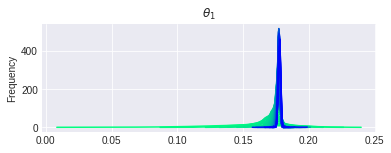

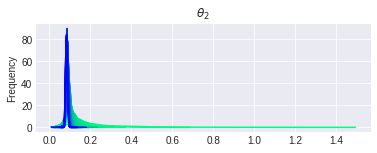

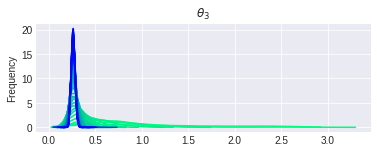

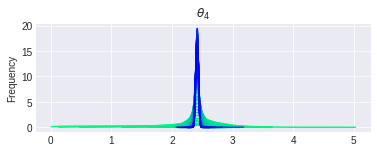

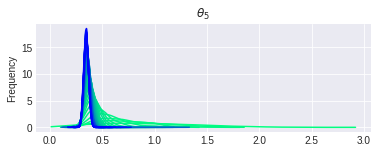

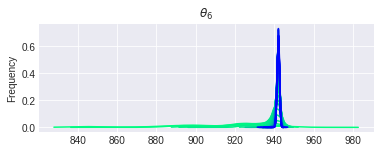

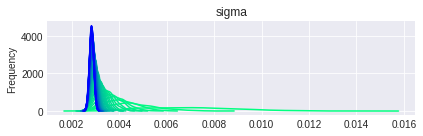

In [18]:
print("Posterior distributions of coefficients after " + str(len(traces)) + " iterations:")
cmap = mpl.cm.winter
j=0
for param in ["theta_1", "theta_2", "theta_3", "theta_4", "theta_5",  "theta_6",   "sigma"]:
    j+=1
    plt.figure(figsize=(6, 2))
    for i, trace in enumerate(traces):
        theta = trace[param]
        x = np.linspace(np.min(theta), np.max(theta), 150)
        y = stats.gaussian_kde(theta)(x)
        plt.plot(x, y, color=cmap(1 - i / len(traces)), label = "%s"%(i+1))
    plt.ylabel("Frequency")
    if j <7:
        plt.title(r'$\theta_%s$'%j)
    else:
        plt.title(param)
    #plt.legend()
plt.tight_layout();

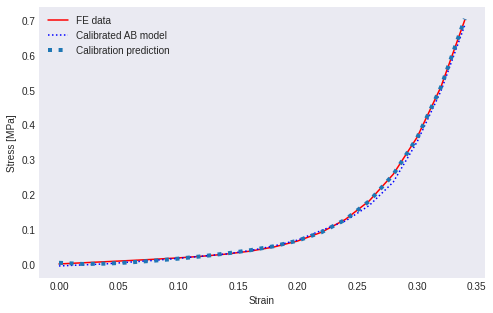

In [44]:
'''
Test in experimental data 
'''


initial_coeffs = np.array([0.3,0,0,0,0,1050])

N = -1
calibrated_coeffs = np.array([np.mean(traces[N]["theta_1"]),
                              np.mean(traces[N]["theta_2"]),
                              np.mean(traces[N]["theta_3"]),
                              np.mean(traces[N]["theta_4"]),
                              np.mean(traces[N]["theta_5"]),
                              np.mean(traces[N]["theta_6"])])


AB_calibrated = [-0.00573361,-0.00269623,0.000366507,0.00547262,0.0103093,0.0161147,0.0224274,0.0288139,0.0384203,0.0515264,0.0686126,0.0963543,0.123549,0.16821,0.235032,0.35073,0.49698,0.686511]


## Create parameters set consisting of certain set of coefficients and all strain values
initial_set = create_parameters_set(strain_fe_media, initial_coeffs)
calibrated_set = create_parameters_set(strain_fe_media, calibrated_coeffs)

## GP predicition 
simY_initial, simMse_initial = GP_model.predict(initial_set)
simY_calibrated, simMse_calibrated = GP_model.predict(calibrated_set)

fig, ax = plt.subplots(figsize=[8, 5])
ax.plot(strain_fe_media, stress_fe_media, label ="FE data", color = "red" )
ax.plot(strain_fe_media, AB_calibrated, ":", label ="Calibrated AB model", color = "blue" )
#plt.plot(strain_fe_media, simY_FE,label = "Initial surrogate prediction")
plt.plot(strain_fe_media,  simY_calibrated, ":", linewidth = "4", label = "Calibration prediction")
plt.xlabel("Strain")
plt.ylabel("Stress [MPa]")
plt.grid()
#plt.title("Surrogate VS FE model")
plt.legend()
#plt.savefig("asss%s.png"%i)

plt.show()